In [1]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = os.path.join("..", "obj", "ner_final.pkl")
with open(path, "rb") as f:
    df = pickle.load(f)

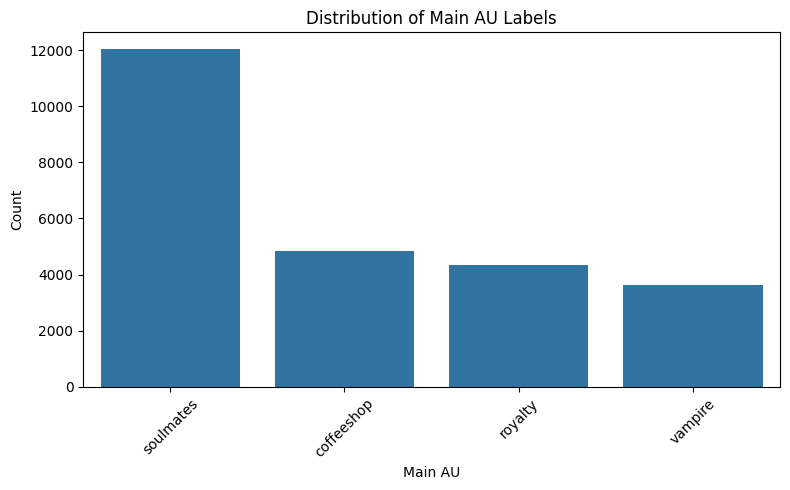

In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Main AU', order=df['Main AU'].value_counts().index)
plt.title('Distribution of Main AU Labels')
plt.xlabel('Main AU')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

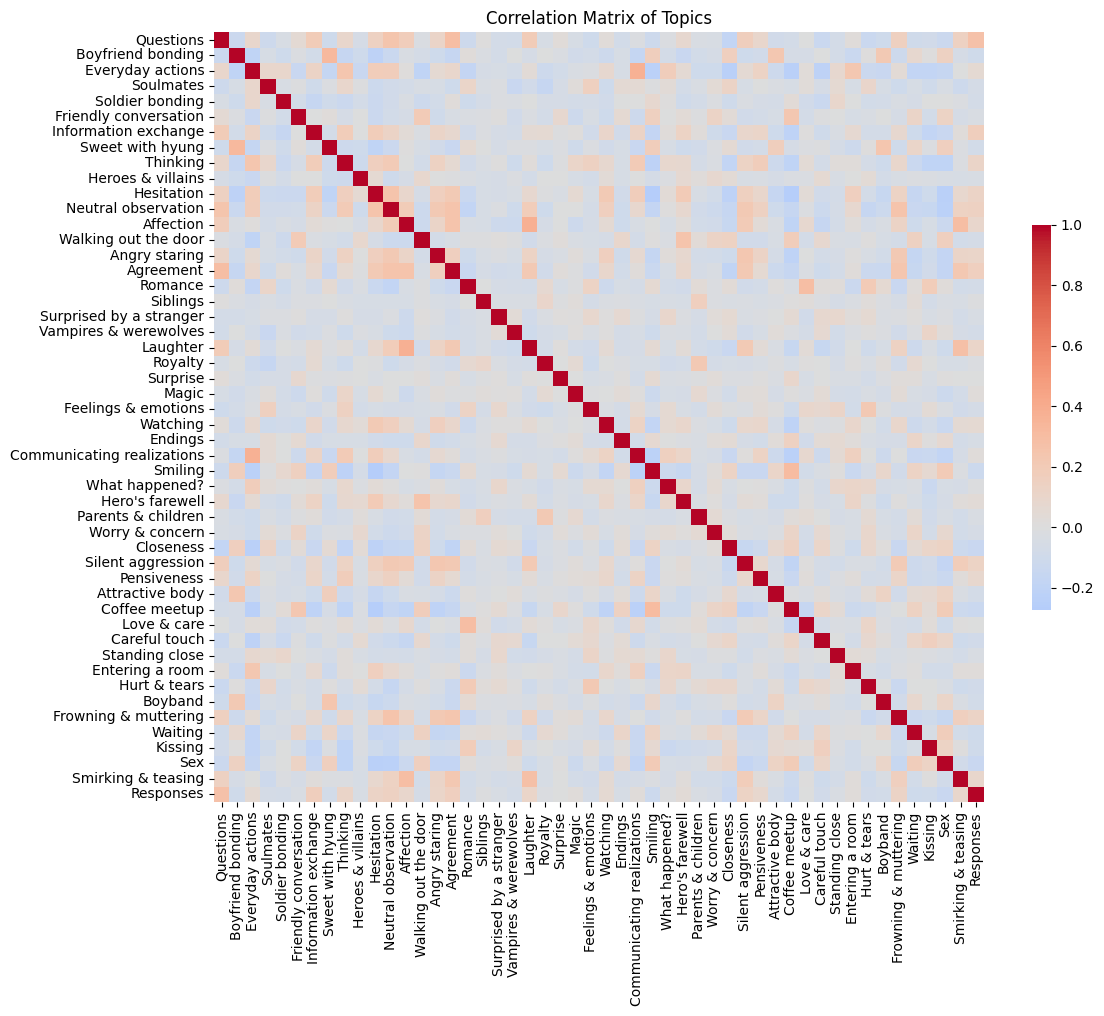

In [ ]:
# Extract only topic columns
topic_cols = df.columns[1:51]  # assuming these are cols 1 to 50
topic_data = df[topic_cols]

plt.figure(figsize=(12, 10))
corr = topic_data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix of Topics')
plt.tight_layout()
plt.show()

# some covariance - use models that can handle it!

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Features and target
X = df.iloc[:, 1:51]
y = df['Main AU']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (stratify to preserve AU distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [8]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'class_weight': ['balanced']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression:", grid_lr.best_params_)
print(classification_report(y_test, grid_lr.predict(X_test), target_names=label_encoder.classes_))


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' 

Best Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

  coffeeshop       0.66      0.90      0.76       969
     royalty       0.83      0.89      0.86       869
   soulmates       0.95      0.78      0.85      2407
     vampire       0.83      0.84      0.83       729

    accuracy                           0.83      4974
   macro avg       0.81      0.85      0.83      4974
weighted avg       0.85      0.83      0.83      4974



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from joblib import parallel
import joblib

# --- Progress bar wrapper for joblib ---
class TqdmJoblib:
    def __init__(self, tqdm_object):
        self.tqdm = tqdm_object

    def __enter__(self):
        self.original_callback = joblib.parallel.BatchCompletionCallBack

        def new_callback(*args, **kwargs):
            self.tqdm.update()
            return self.original_callback(*args, **kwargs)

        joblib.parallel.BatchCompletionCallBack = new_callback

    def __exit__(self, exc_type, exc_val, exc_tb):
        joblib.parallel.BatchCompletionCallBack = self.original_callback

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [10, 20, 50, 100],
    'class_weight': ['balanced'],
    'max_features': [0.6, 0.8, 1],
}

# Total jobs = param combos × folds
from sklearn.model_selection import ParameterGrid
n_total = len(ParameterGrid(param_grid_rf)) * 5  # 5-fold CV

# --- GridSearchCV with tqdm ---
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
)

with tqdm(total=n_total, desc="GridSearchCV Progress") as progress_bar:
    with TqdmJoblib(progress_bar):
        grid_rf.fit(X_train, y_train)

# --- Results ---
print("Best Random Forest:", grid_rf.best_params_)
print(classification_report(y_test, grid_rf.predict(X_test), target_names=label_encoder.classes_))

GridSearchCV Progress:   0%|          | 0/2880 [00:00<?, ?it/s]

Best Random Forest: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

  coffeeshop       0.80      0.86      0.83       969
     royalty       0.89      0.91      0.90       869
   soulmates       0.92      0.89      0.91      2407
     vampire       0.86      0.86      0.86       729

    accuracy                           0.88      4974
   macro avg       0.87      0.88      0.87      4974
weighted avg       0.88      0.88      0.88      4974



In [33]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Step 1: Get the top 10 parameter sets by mean_test_score
results_df = pd.DataFrame(grid_rf.cv_results_)
top_10 = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Step 2: Prepare a list to collect summary info
summary_list = []

# Step 3: Retrain and save models
for rank, (idx, row) in tqdm(enumerate(top_10.iterrows(), start=1)):
    params = row['params']
    
    # Retrain model
    #model = RandomForestClassifier(random_state=42, **params)
    #model.fit(X_train, y_train)

    # Save model
    #model_filename = f"rf_model_top{rank}.pkl"
    #with open(model_filename, 'wb') as f:
    #    pickle.dump(model, f)
    #print(f"Saved: {model_filename}")

    # Collect summary info
    summary_list.append({
        'rank': rank,
        'model_filename': model_filename,
        'params': params,
        'mean_test_score': row['mean_test_score'],
        'std_test_score': row['std_test_score'],
    })

# Step 4: Create summary DataFrame
summary_df = pd.DataFrame(summary_list)

# Step 5: Pickle the summary table
#with open("rf_top10_summary.pkl", "wb") as f:
#    pickle.dump(summary_df, f)

#print("Saved: rf_top10_summary.pkl")



0it [00:00, ?it/s]

In [34]:
summary_df

,rank,model_filename,params,mean_test_score,std_test_score
0,1,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.874027,0.004145
1,2,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.873437,0.004422
2,3,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.873389,0.004329
3,4,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.873291,0.004523
4,5,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.873271,0.004799
5,6,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.872819,0.004056
6,7,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.872593,0.005338
7,8,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.872462,0.003451
8,9,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.872455,0.003735
9,10,rf_model_top10.pkl,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.872219,0.004753


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import xgboost as xgb
from tqdm.auto import tqdm
import joblib

# --- Progress bar wrapper for joblib ---
class TqdmJoblib:
    def __init__(self, tqdm_object):
        self.tqdm = tqdm_object

    def __enter__(self):
        self.original_callback = joblib.parallel.BatchCompletionCallBack

        def new_callback(*args, **kwargs):
            self.tqdm.update()
            return self.original_callback(*args, **kwargs)

        joblib.parallel.BatchCompletionCallBack = new_callback

    def __exit__(self, exc_type, exc_val, exc_tb):
        joblib.parallel.BatchCompletionCallBack = self.original_callback

# --- XGBoost param grid ---
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth' : [5, 10, 20, 50],
    'colsample_bytree': [0.6, 0.8, 1],
    'learning_rate': [2e-3, 2e-2, 2e-1]
}

# --- Total grid runs × CV folds ---
n_total = len(ParameterGrid(param_grid_xgb)) * 5  # 3-fold CV

# --- GridSearchCV with tqdm ---
grid_xgb = GridSearchCV(
    xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
)

with tqdm(total=n_total, desc="XGBoost GridSearchCV Progress") as progress_bar:
    with TqdmJoblib(progress_bar):
        grid_xgb.fit(X_train, y_train)

# --- Results ---
print("Best XGBoost:", grid_xgb.best_params_)
print(classification_report(y_test, grid_xgb.predict(X_test), target_names=label_encoder.classes_))


XGBoost GridSearchCV Progress:   0%|          | 0/540 [00:00<?, ?it/s]

Best XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

  coffeeshop       0.84      0.86      0.85       969
     royalty       0.91      0.90      0.90       869
   soulmates       0.90      0.92      0.91      2407
     vampire       0.90      0.84      0.87       729

    accuracy                           0.89      4974
   macro avg       0.89      0.88      0.88      4974
weighted avg       0.89      0.89      0.89      4974



In [32]:
import pickle
import pandas as pd
import xgboost as xgb

# Step 1: Get the top 10 parameter sets from XGBoost grid search
results_df = pd.DataFrame(grid_xgb.cv_results_)
top_10 = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Step 2: Prepare a list to store summary info
summary_list = []

# Step 3: Retrain and pickle top 10 XGBoost models
for rank, (idx, row) in enumerate(top_10.iterrows(), start=1):
    params = row['params']
    
    # Retrain model with best parameters
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42,
        **params
    )
    model.fit(X_train, y_train)

    # Save model
    model_name = f"xgb_model_top{rank}.pkl"
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {model_name}")

    # Collect summary info
    summary_list.append({
        'rank': rank,
        'model_filename': model_name,
        'params': params,
        'mean_test_score': row['mean_test_score'],
        'std_test_score': row['std_test_score'],
    })

# Step 4: Create summary DataFrame
summary_df = pd.DataFrame(summary_list)

# Step 5: Pickle the summary table
with open("xgb_top10_summary.pkl", "wb") as f:
    pickle.dump(summary_df, f)

print("Saved: xgb_top10_summary.pkl")


Saved: xgb_model_top1.pkl
Saved: xgb_model_top2.pkl
Saved: xgb_model_top3.pkl
Saved: xgb_model_top4.pkl
Saved: xgb_model_top5.pkl
Saved: xgb_model_top6.pkl
Saved: xgb_model_top7.pkl
Saved: xgb_model_top8.pkl
Saved: xgb_model_top9.pkl
Saved: xgb_model_top10.pkl
Saved: xgb_top10_summary.pkl


In [35]:
with pd.option_context('display.max_colwidth', None):
    print(summary_df['params'])


0    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 200}
1    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 500}
2    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 500}
3    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 500}
4    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 500}
5    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 200}
6    {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.6, 'min_samples_split': 10, 'n_estimators': 200}
7    {'ccp_alpha': 0.0, 'class_weight': 'balance

In [ ]:
import pickle
import pandas as pd
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# --- Load your test set (make sure this matches your split) ---
# X_test, y_test should already exist in your workspace

# --- Helper function to load and evaluate models ---
def evaluate_models(prefix: str, ModelClass):
    # Load saved table
    table_path = f"{prefix}_top10_table.pkl"
    df = pd.read_pickle(table_path)

    f1_scores = []

    for i in range(10):
        model_path = f"{prefix}_model_top{i+1}.pkl"
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_scores.append(f1)

        print(f"{prefix} Model {i+1}: F1-macro = {f1:.4f}")

    # Add column to table and save
    df['f1_macro_test'] = f1_scores
    df.to_pickle(f"{prefix}_top10_table_with_test.pkl")
    print(f"\nUpdated table saved as: {prefix}_top10_table_with_test.pkl")

# --- Run for RF ---
evaluate_models("rf", RandomForestClassifier)

# --- Run for XGB ---
evaluate_models("xgb", xgb.XGBClassifier)
